# Project Title

**Authors:** Brandon Sienkiewicz, Ilan Haskel, Zach Cherna


## Overview

Insert overview

## Business Problem

Insert business problem

## Data Understanding

The provided data contains information on movies from various websites. These data sets include general information about the movies as well as more specific data such as rating, production cost, and total gross.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns

conn = sqlite3.connect('zippedData/im.db')
%matplotlib inline

In [2]:
bom_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
rtm_df = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep = "\t")
rtr_df = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep = "\t", encoding = 'latin1')
tmdb_df = pd.read_csv('zippedData/tmdb.movies.csv.gz')
tn_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
imbd_df = pd.read_sql("""
SELECT *
FROM movie_basics b
JOIN movie_ratings r
ON b.movie_id = r.movie_id
""", conn)

## Data Preparation and Modelling

### Data Preparation 1

# Analysis of Genres Vs. AverageRating

In [3]:
imbd_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,movie_id,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",tt0063540,7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",tt0066787,7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,tt0069049,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",tt0069204,6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",tt0100275,6.5,119
...,...,...,...,...,...,...,...,...,...
73851,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.0,Documentary,tt9913084,6.2,6
73852,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,"Drama,Family",tt9914286,8.7,136
73853,tt9914642,Albatross,Albatross,2017,NaN,Documentary,tt9914642,8.5,8
73854,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,NaN,None,tt9914942,6.6,5


In [4]:
imbd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   movie_id         73856 non-null  object 
 7   averagerating    73856 non-null  float64
 8   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 5.1+ MB


In [5]:
imbd_df['genres'].isna().sum()

804

-'genres' has 804 null values out of 73856 total entries. This is equal to 1.08%, therefore we will drop the null values for 'genres'.

In [6]:
imbd_df_clean_genres = imbd_df.dropna(subset = ['genres'])

In [7]:
imbd_df_clean_genres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73052 entries, 0 to 73855
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73052 non-null  object 
 1   primary_title    73052 non-null  object 
 2   original_title   73052 non-null  object 
 3   start_year       73052 non-null  int64  
 4   runtime_minutes  65720 non-null  float64
 5   genres           73052 non-null  object 
 6   movie_id         73052 non-null  object 
 7   averagerating    73052 non-null  float64
 8   numvotes         73052 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 5.6+ MB


In [8]:
imbd_df_clean_genres['genres'].value_counts()[:50]

Drama                            11612
Documentary                      10313
Comedy                            5613
Horror                            2692
Comedy,Drama                      2617
Thriller                          1555
Drama,Romance                     1510
Comedy,Romance                    1236
Comedy,Drama,Romance              1208
Horror,Thriller                   1004
Drama,Thriller                     990
Action                             979
Romance                            717
Biography,Documentary              694
Documentary,Drama                  582
Comedy,Horror                      579
Documentary,Music                  579
Action,Crime,Drama                 562
Crime,Drama,Thriller               504
Crime,Drama                        494
Family                             491
Biography,Documentary,History      479
Drama,Family                       478
Documentary,History                476
Action,Drama                       395
Horror,Mystery,Thriller  

Using only single-genre values of 'genre' ex: Drama, Documentary, Comedy, Horror, Thriller, Action, Romance, Family, Animation, Sci-Fi, Crime   

In [10]:
drama_mean = imbd_df_clean_genres[imbd_df_clean_genres['genres']=='Drama'].mean()
drama_mean

start_year         2014.273424
runtime_minutes      97.633723
averagerating         6.494265
numvotes            723.003875
dtype: float64

In [11]:
drama_mean_rating = drama_mean['averagerating']
drama_mean_rating

6.494264553909748

In [12]:
documentary_mean = imbd_df_clean_genres[imbd_df_clean_genres['genres']=='Documentary'].mean()
documentary_mean

start_year         2014.507903
runtime_minutes      88.942179
averagerating         7.293794
numvotes            173.132260
dtype: float64

In [14]:
documentary_mean_rating = documentary_mean['averagerating']
documentary_mean_rating

7.293794240279259

In [15]:
comedy_mean = imbd_df_clean_genres[imbd_df_clean_genres['genres']=='Comedy'].mean()
comedy_mean

start_year         2014.342063
runtime_minutes      96.187880
averagerating         5.777998
numvotes           1217.181008
dtype: float64

In [16]:
comedy_mean_rating = comedy_mean['averagerating']
comedy_mean_rating

5.77799750579013

In [17]:
horror_mean = imbd_df_clean_genres[imbd_df_clean_genres['genres']=='Horror'].mean()
horror_mean

start_year         2014.450966
runtime_minutes      85.769265
averagerating         4.835475
numvotes            589.128158
dtype: float64

In [18]:
horror_mean_rating = horror_mean['averagerating']
horror_mean_rating

4.835475482912332

In [19]:
thriller_mean = imbd_df_clean_genres[imbd_df_clean_genres['genres']=='Thriller'].mean()
thriller_mean

start_year         2014.702251
runtime_minutes      94.880435
averagerating         5.704244
numvotes            283.320900
dtype: float64

In [20]:
thriller_mean_rating = thriller_mean['averagerating']
thriller_mean_rating

5.704244372990355

In [21]:
action_mean = imbd_df_clean_genres[imbd_df_clean_genres['genres']=='Action'].mean()
action_mean

start_year         2014.271706
runtime_minutes     103.201110
averagerating         5.757712
numvotes            336.115424
dtype: float64

In [22]:
action_mean_rating = action_mean['averagerating']
action_mean_rating

5.7577119509703785

In [23]:
romance_mean = imbd_df_clean_genres[imbd_df_clean_genres['genres']=='Romance'].mean()
romance_mean

start_year         2014.557880
runtime_minutes     110.408318
averagerating         6.051883
numvotes            194.746165
dtype: float64

In [24]:
romance_mean_rating = romance_mean['averagerating']
romance_mean_rating

6.051882845188285

In [25]:
family_mean = imbd_df_clean_genres[imbd_df_clean_genres['genres']=='Family'].mean()
family_mean

start_year         2014.739308
runtime_minutes      90.210024
averagerating         6.078004
numvotes            101.890020
dtype: float64

In [26]:
family_mean_rating = family_mean['averagerating']
family_mean_rating

6.078004073319756

In [27]:
animation_mean = imbd_df_clean_genres[imbd_df_clean_genres['genres']=='Animation'].mean()
animation_mean

start_year         2014.652299
runtime_minutes      81.901060
averagerating         5.908621
numvotes             76.083333
dtype: float64

In [28]:
animation_mean_rating = animation_mean['averagerating']
animation_mean_rating

5.908620689655173

In [29]:
scifi_mean = imbd_df_clean_genres[imbd_df_clean_genres['genres']=='Sci-Fi'].mean()
scifi_mean

start_year         2014.691525
runtime_minutes      89.242553
averagerating         5.440678
numvotes            167.349153
dtype: float64

In [30]:
scifi_mean_rating = scifi_mean['averagerating']
scifi_mean_rating

5.440677966101695

In [31]:
crime_mean = imbd_df_clean_genres[imbd_df_clean_genres['genres']=='Crime'].mean()
crime_mean

start_year         2014.559701
runtime_minutes      93.850746
averagerating         5.920149
numvotes            158.395522
dtype: float64

In [32]:
crime_mean_rating = crime_mean['averagerating']
crime_mean_rating

5.920149253731343

In [33]:
data = [['drama', drama_mean_rating ],
        ['documentary', documentary_mean_rating],
        ['comedy', comedy_mean_rating],
        ['horror', horror_mean_rating],
        ['thriller', thriller_mean_rating],
        ['action', action_mean_rating],
        ['romance', romance_mean_rating],
        ['family', family_mean_rating],
        ['animation', animation_mean_rating],
        ['sci-fi', scifi_mean_rating],
        ['crime', crime_mean_rating]]

In [34]:
genre_means = pd.DataFrame(data, columns = ['genre', 'rating'])

In [35]:
genre_means = genre_means.sort_values(by = 'rating')

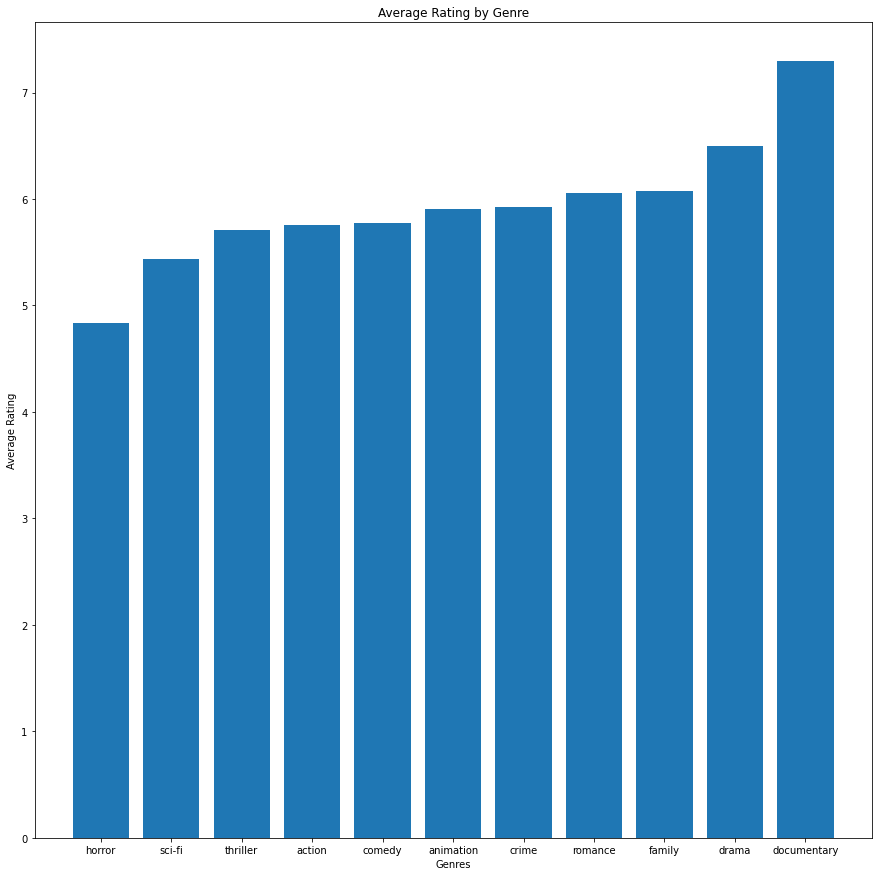

In [36]:
fig, ax = plt.subplots(figsize = (15,15))

x = genre_means['genre']
y = genre_means['rating']

ax.set_xlabel("Genres")
ax.set_ylabel("Average Rating")
ax.set_title("Average Rating by Genre")

ax.bar(x,y);

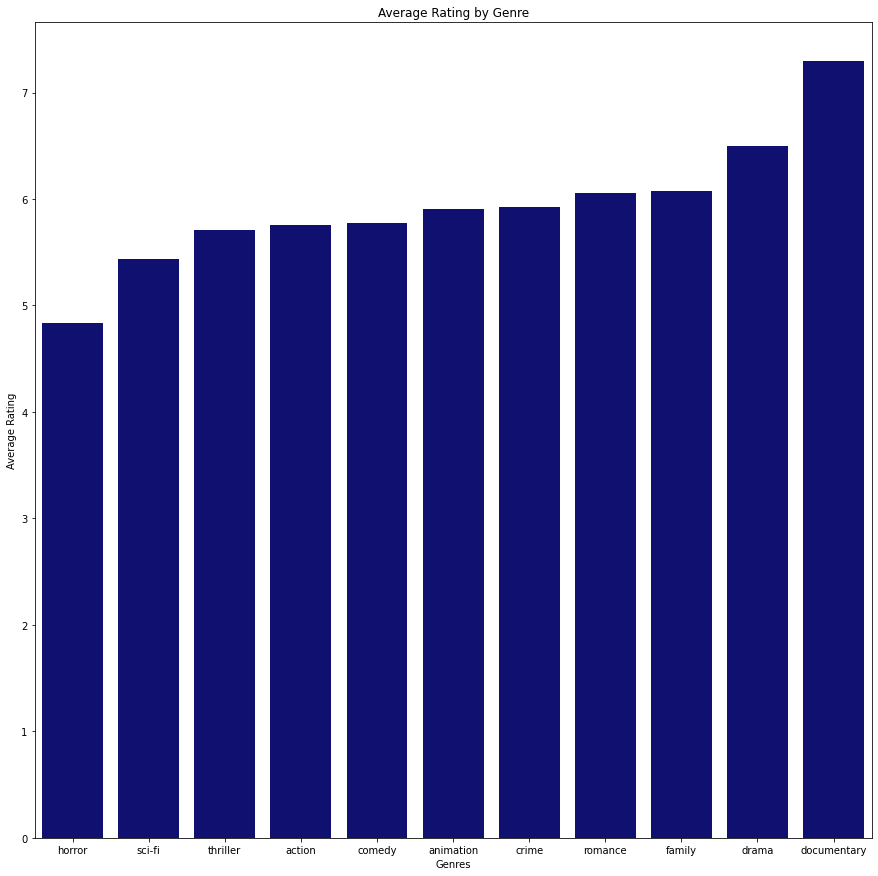

In [37]:
plt.figure(figsize=(15,15))
sns.barplot(data = genre_means, x='genre', y='rating', color="navy").set(title = "Average Rating by Genre", xlabel = "Genres", ylabel = "Average Rating")
plt.show()

Analysis of average rating by genre shows Horror movies have the worst rating of 4.83, while Documentaries have the highest rating of 7.29. - need to add avg rating numbers to each bar 

### Data Modelling 1

### Data Preparation 2

### Data Modelling 2

### Data Preparation 3

### Data Modelling 3

## Evaluation

## Conclusion